# WGAN-GP
WGAN-GP uses gradient penalty on top of WGAN to remove the Lipschitz constraint.

In [34]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import make_grid

%matplotlib inline
sns.set()

In [35]:
class Critic(nn.Module):
    def __init__(self, channels, features_d, classes, height, width):
        super(Critic, self).__init__()
        self.height = height
        self.width = width
        
        self.disc = nn.Sequential(
            # Input: N x channels x 64 x 64
            nn.Conv2d(
                in_channels=channels+1, # extra channel for embedding of what label is coming
                out_channels=features_d,
                kernel_size=4,
                stride=2,
                padding=1,
            ), # 32x32
            nn.LeakyReLU(negative_slope=2e-1, inplace=True),
            self._block(in_channels=features_d, out_channels=features_d*2, kernel_size=4, stride=2, padding=1), # 16x16
            self._block(in_channels=features_d*2, out_channels=features_d*4, kernel_size=4, stride=2, padding=1), # 8x8
            self._block(in_channels=features_d*4, out_channels=features_d*8, kernel_size=4, stride=2, padding=1), # 4x4
            nn.Conv2d(
                in_channels=features_d*8,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=0,
            ), #1x1
            # nn.Sigmoid(), no sigmoid at last, for wgan, we work with logits
        )
        
        # embedding for conditional gan, basically we are making another channel
        self.embedding = nn.Embedding(num_embeddings=classes, embedding_dim=height*width)
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
#             nn.BatchNorm2d(num_features=out_channels),
            nn.InstanceNorm2d(num_features=out_channels, affine=True), # LayerNorm ~ InstanceNorm, but in the paper they used layernorm, affine=True makes the module learnable
#             nn.LayerNorm(normalized_shape=out_channels, elementwise_affine=True), # elementwise_affine=True makes the module learnable
            nn.LeakyReLU(negative_slope=2e-1, inplace=True),
        )
            
    def forward(self, x, labels):
        embedding = self.embedding(labels).view(labels.shape[0], 1, self.height, self.width)
        x = torch.cat([x, embedding], dim=1) # first dimension is batch size
        return self.disc(x)

In [36]:
class Generator(nn.Module):
    def __init__(self, latent_dim, channels_img, features_g, classes, embedding_size):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x latent_dim x 1 x 1
            self._block(in_channels=latent_dim+embedding_size, out_channels=features_g*16, kernel_size=4, stride=1, padding=0), # N x f_g*16 x 4 x 4; +embedding_size for the embedding
            self._block(in_channels=features_g*16, out_channels=features_g*8, kernel_size=4, stride=2, padding=1), # 8x8
            self._block(in_channels=features_g*8, out_channels=features_g*4, kernel_size=4, stride=2, padding=1), # 16x16
            self._block(in_channels=features_g*4, out_channels=features_g*2, kernel_size=4, stride=2, padding=1), # 32x32
            nn.ConvTranspose2d(
                in_channels=features_g*2,
                out_channels=channels_img,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.Tanh(),
        )
        
        self.embedding = nn.Embedding(num_embeddings=classes, embedding_dim=embedding_size) # this embedding has to be added to the noise latent vector
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=out_channels), 
            nn.ReLU(inplace=True),
        )
            
    def forward(self, x, labels):
        # latent vector: N x noise_dim x 1 x 1
        embedding = self.embedding(labels).unsqueeze(dim=2).unsqueeze(dim=3) # adding embedding to labels
        x = torch.cat([x, embedding], dim=1)
        return self.gen(x)

In [37]:
def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [38]:
def gradient_penalty(critic, labels, real, fake):
    BATCH_SIZE, CHANNELS, HEIGHT, WIDTH = real.shape
    # epsilon should be U[0, 1] which is statisfied by torch.rand
    epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, CHANNELS, HEIGHT, WIDTH).to(DEVICE) # implies we want only one value for each dimension but we want, it as the shape of the image
    interpolated_images = real * epsilon + fake * (1 - epsilon)
    
    # calculate the critic score
    mixed_scores = critic(interpolated_images, labels) # we call it mixed scores, as it the scores of the interpolated images
    
    gradient = torch.autograd.grad(inputs=interpolated_images, outputs=mixed_scores, grad_outputs=torch.ones_like(mixed_scores), create_graph=True, retain_graph=True)[0]
    
    gradient.view(gradient.shape[0], -1) # flattenning to take the norm
    
    # norm is basically finding, how big one vector/matrix is to the other
    # l1 norm is the sum of all the absolute components for vectors
    # l2 norm is the sqrt of the sum of squares of all the components for vectors
    
    # l1 and l2 norm have slightly different expression than that of vectors
    
    gradient_norm = gradient.norm(p=2, dim=1,) # l2 norm is used
    
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    
    return gradient_penalty

In [39]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 5
LEARNING_RATE = 1e-4
LATENT_DIM = 100
CHANNELS = 1
CLASSES = 10
GENERATOR_EMBEDDING = 100
FEATURES_DISC = 64
FEATURES_GEN = 64
IMG_SIZE = 64
BATCH_SIZE = 64
CRITIC_ITERATIONS = 5
GRADIENT_PENALTY_LAMBDA = 10

In [40]:
transform = transforms.Compose(
    [transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor(), transforms.Normalize([5e-1 for _ in range(CHANNELS)], [5e-1 for _ in range(CHANNELS)], inplace=True)]
)

In [41]:
# MNIST
dataset = datasets.MNIST(root='./dataset', download=True, train=True, transform=transform)
CHANNELS = 1
CLASSES = 10

In [42]:
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), drop_last=True, shuffle=True, pin_memory=True)

In [43]:
fixed_noise = torch.randn((32, LATENT_DIM, 1, 1)).to(DEVICE)

critic = Critic(channels=CHANNELS, features_d=FEATURES_DISC, classes=CLASSES, height=IMG_SIZE, width=IMG_SIZE).to(DEVICE)
gen = Generator(latent_dim=LATENT_DIM, channels_img=CHANNELS, features_g=FEATURES_GEN, classes=CLASSES, embedding_size=GENERATOR_EMBEDDING).to(DEVICE)

init_weights(critic)
init_weights(gen)

optim_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0, 9e-1))
optim_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0, 9e-1))

# training mode
critic.train()
gen.train() 

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpla

In [44]:
real_imgs = []
fake_imgs = []
for epoch in range(1, EPOCHS + 1):
    for batch_idx, (real_img, labels) in enumerate(loader):
        real_img = real_img.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # train the critic: max E[critic(x)] - E[critic(z)]
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1).to(DEVICE)
            fake_img = gen(noise, labels)
            
            critic_real = critic(real_img, labels).view(-1)
            critic_fake = critic(fake_img.detach(), labels).view(-1)
            
            # gradient penalty
            gp = gradient_penalty(critic, labels, real_img, fake_img)

            lossC = -(torch.mean(critic_real) - torch.mean(critic_fake)) + GRADIENT_PENALTY_LAMBDA * gp

            critic.zero_grad()
            lossC.backward(retain_graph=True)
            optim_critic.step()
            
        # train the generator: min -E[critic(gen(z))]
        output = critic(fake_img, labels).view(-1)
        lossG = -torch.mean(output)
        
        gen.zero_grad()
        lossG.backward()
        optim_gen.step()
                
        if not (batch_idx % 100) and batch_idx > 0:
            print(f'Epoch: [{epoch}/{EPOCHS}] | Batch: [{batch_idx}/{len(loader)}] | LossC: {lossC:.4f} | LossG: {lossG:.4f}')
            with torch.inference_mode():
                fake_img = gen(noise, labels) # trying to generate the same label from noise
                
                img_grid_fake = make_grid(fake_img[:32], normalize=True)
                img_grid_real = make_grid(real_img[:32], normalize=True)

                fake_imgs.append(img_grid_fake)
                real_imgs.append(img_grid_real)                

Epoch: [1/5] | Batch: [100/937] | LossC: -683.1041 | LossG: 344.8548
Epoch: [1/5] | Batch: [200/937] | LossC: -1283.8519 | LossG: 645.3041
Epoch: [1/5] | Batch: [300/937] | LossC: -1988.9475 | LossG: 998.9236
Epoch: [1/5] | Batch: [400/937] | LossC: -2686.7798 | LossG: 1334.4497
Epoch: [1/5] | Batch: [500/937] | LossC: -3302.3577 | LossG: 1642.4514
Epoch: [1/5] | Batch: [600/937] | LossC: -3764.0920 | LossG: 2062.9590
Epoch: [1/5] | Batch: [700/937] | LossC: -4509.4863 | LossG: 2444.4282
Epoch: [1/5] | Batch: [800/937] | LossC: -4300.4956 | LossG: 2777.3057
Epoch: [1/5] | Batch: [900/937] | LossC: -4642.6079 | LossG: 3237.7007
Epoch: [2/5] | Batch: [100/937] | LossC: -4348.3486 | LossG: 3366.1777
Epoch: [2/5] | Batch: [200/937] | LossC: -4504.0278 | LossG: 3967.9761
Epoch: [2/5] | Batch: [300/937] | LossC: -4754.1055 | LossG: 4653.1499
Epoch: [2/5] | Batch: [400/937] | LossC: -4188.7090 | LossG: 3459.0337
Epoch: [2/5] | Batch: [500/937] | LossC: -4044.0415 | LossG: 4572.9775
Epoch: [2/

KeyboardInterrupt: 

(-0.5, 529.5, 265.5, -0.5)

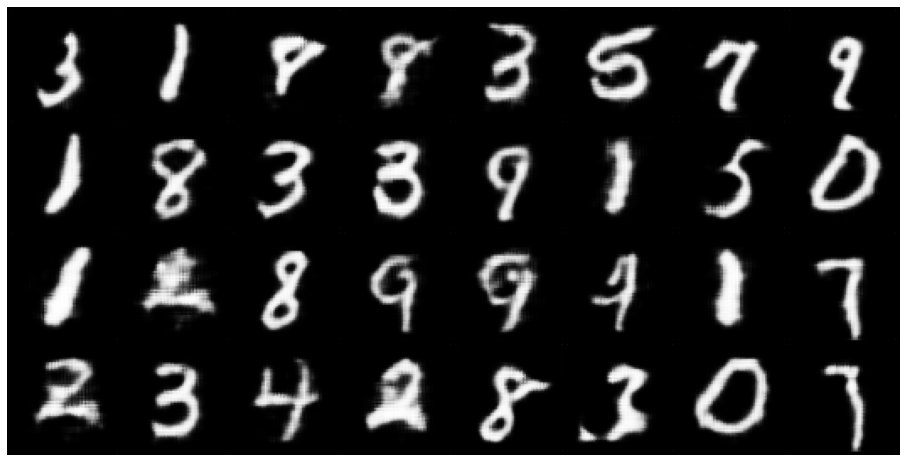

In [45]:
plt.figure(figsize=(16, 16))
plt.imshow(fake_imgs[-1].cpu().numpy().transpose((1, 2, 0)))
plt.axis('off')

(-0.5, 529.5, 265.5, -0.5)

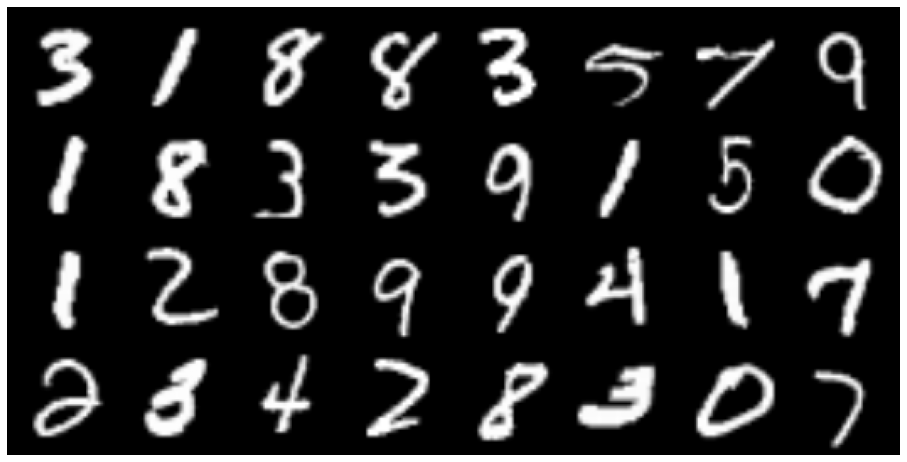

In [46]:
plt.figure(figsize=(16, 16))
plt.imshow(real_imgs[-1].cpu().numpy().transpose((1, 2, 0)))
plt.axis('off')